In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [3]:
def build_data_arrays(SR, SB, gaiadata2):
    X = SR[:,3]-center_ra
    Y = SR[:,2]-center_dec

    Xb = SB[:,3]-center_ra
    Yb = SB[:,2]-center_dec
    
    Xad = gaiadata2[:, 3]-center_ra
    Yad = gaiadata2[:, 2]-center_dec

    SR = np.c_[SR[:,0],SR[:,1],X, Y, SR[:,4],SR[:,5]]
    SB = np.c_[SB[:,0],SB[:,1],Xb, Yb, SB[:,4],SB[:,5]]
    gaiadata2 = np.c_[gaiadata2[:,0],gaiadata2[:,1], Xad, Yad, gaiadata2[:,4],gaiadata2[:,5]]
    
    return SR, SB, gaiadata2

In [4]:
threshold_arr_size = 10000

In [5]:
def calc_diff(SR, SB):
    return abs(len(SR) - len(SB))

In [6]:
def find_SR_SB_pointers(pointers, increment, data_arr, start_point, end_point):
    SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
    SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]

    previous_diff = calc_diff(SR, SB)
    prev_SR, prev_SB = SR, SB
    curr_diff = previous_diff
    bottom_bool = False
    top_bool = True

    while curr_diff <= previous_diff and pointers[3] < end_point:
        previous_diff, prev_SR, prev_SB = curr_diff, SR, SB
        if bottom_bool:
            pointers[0] = max(start_point, pointers[0] - increment)
        else:
            pointers[3] = min(end_point, pointers[3] + increment)
        bottom_bool, top_bool = top_bool, bottom_bool
        SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
        SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]
        curr_diff = calc_diff(SR, SB)

    return prev_SR, prev_SB

In [7]:
def build_model(SR, SB, num_models, all_data, pointers, colors, filename, iter_num):
    
    X = np.concatenate([SR,SB])
    Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB))])

    myscalar = preprocessing.StandardScaler()
    myscalar.fit(X)
    X_scaled = myscalar.transform(X)
    all_data_scaled = myscalar.transform(all_data)

    X_scaled = X_scaled[Y<2]
    Y = Y[Y<2]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)


    for i in range(num_models):
        
        print('working')

        #set biases for each layer, bias_initializer
        #initializers.GlorotNormal()
        model = Sequential()
        initializer =tf.keras.initializers.glorot_normal()
        model.add(Dense(64, input_dim=5, activation='relu', bias_initializer = initializer)) 
        model.add(Dense(64, activation='relu', bias_initializer = initializer))
        model.add(Dense(64, activation='relu', bias_initializer = initializer))
        model.add(Dense(1, activation='sigmoid', bias_initializer = initializer))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0) 

        preds = model.predict(X_test[:,1:], batch_size=int(0.1*len(X_test)))
        preds_all = model.predict(all_data_scaled[:, 1:])
        
        #cut on color
        cuts = [0.,0.5,0.9,0.99, 0.999]
        bins_cuts = np.zeros((len(cuts), 99))
        
        plt.figure(figsize = (12, 12))
        plt.yscale('log')
        plt.ylim([1, 10e5])
        plt.axvline(pointers[1], color = 'black')
        plt.axvline(pointers[2], color = 'black')
        plt.axvline(pointers[0], color = 'gray')
        plt.axvline(pointers[3], color = 'gray')
        title_str = 'Cuts on pmdec'
        plt.ylabel('Counts', fontsize = 20)
        plt.xlabel('PMDEC', fontsize= 20)
        stars_passing_cut = []
        for j in range(len(cuts)):
            cut = cuts[j]
            X_unscaled = myscalar.inverse_transform(X_scaled[:, :6])
            all_data_unscaled = myscalar.inverse_transform(all_data_scaled[:, :6])
            
            X_pass_all = all_data_unscaled[(preds_all[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
            plt.hist(X_pass_all[:,0], bins = np.linspace(-30, 15, 100), color = colors[j], alpha = 1, histtype = 'step', label = str(cut*100) + 'th Percentile')
            #finding stars passing cut
#             if cut == 0.99:
#                 stars_passing_cut = X_pass_all[(X_pass_all[:,0] > pointers[1]) * (X_pass_all[:,0] < pointers[2])]
        
#         quantile = 100/len(preds[Y_test==1])
#         stars_passing_cut = all_data_unscaled[(preds_all[:,0]) > np.quantile(preds[Y_test == 1], [1 - quantile])[0]]
        preds_all_sorted = preds_all[np.argsort(preds_all[:,0])]
#         print(preds_all_sorted)
#         print(preds_all_sorted[:,0])
        all_data_sorted = all_data[np.argsort(preds_all[:,0])]
#         print(all_data)
#         print(all_data_sorted)
        all_data_sorted = all_data_sorted[(all_data_sorted[:,0] > pointers[1]) * (all_data_sorted[:,0] < pointers[2])]
        stars_passing_cut = all_data_sorted[len(all_data_sorted) - 300:]
        plt.text((pointers[1] + pointers[2])/2, 1e5, 'SR', fontsize = 20)
        plt.legend()
        plt.savefig('figures_gd1_end/scanning_plots' + filename[28:].replace('.', '_') + '_' + str(iter_num) + '.pdf')
        plt.clf()
        
        plt.figure(figsize = (12, 12))
        plt.scatter(stars_passing_cut[:,3],stars_passing_cut[:,2])
        plt.savefig('figures_gd1_end/stars_passing_cut' + filename[28:].replace('.', '_') + '_' + str(iter_num) + '.pdf')
        plt.clf()

In [8]:
def scan_and_plot(gaiadata2, filename):
    iter_num = 0
    start_point = min(gaiadata2[:,0])
    pointers = np.zeros(4)
    signal_size = 4
    signal_increment = 2
    sb_start_diff = 0.5
    pointers[0] = start_point
    pointers[1] = start_point + sb_start_diff
    pointers[2] = pointers[1] + signal_size
    pointers[3] = pointers[2] + sb_start_diff
    end_point = max(gaiadata2[:,0])
    colors = ['red', 'orange', 'green', 'blue', 'purple']

    while pointers[3] <= end_point:
        SR, SB = find_SR_SB_pointers(pointers, sb_start_diff, gaiadata2, start_point, end_point)
        if len(SR) >= threshold_arr_size:
            SR, SB, all_data = build_data_arrays(SR, SB, gaiadata2)
            build_model(SR, SB, 1, all_data, pointers, colors, filename, iter_num)
            iter_num += 1
        pointers[1] += signal_increment
        pointers[2] += signal_increment
        pointers[0] = pointers[1] - sb_start_diff
        pointers[3] = pointers[2] + sb_start_diff

In [10]:
datafile = '/data0/users/bpnachman/Gaia/gaiascan_l101.2_b58.4_ra212.7_dec55.2.npy'
gaiadata=np.load(datafile,allow_pickle=True)
gaiadata2 = np.array(gaiadata[:,[9,8,6,7,4,5]]).astype('float32') 
#pm_lat, pm_lon_coslat, lon, lat, color, mag
allgd1stars = np.load('gd1_stars.npy')
is_stream_arr, gaiadata3 = FilterGD1(gaiadata)

new_gaiadata = []
for i in range(len(gaiadata)):
    temp = np.append(gaiadata[i], is_stream_arr[i])
    new_gaiadata.append(temp)

In [11]:
new_gaiadata

[array([  -4.85076237,    1.86339891,   49.70929718, -129.99530029,
           0.96725273,   15.59235191,   11.11726088,   -4.15471877,
           2.99496137,   -4.24645233,    0.        ]),
 array([  -6.81769562,   -3.96874118,   52.22753143, -126.11940002,
           1.24362755,   19.81727409,   12.78607192,   -1.07022908,
          -1.76597547,   -7.68851156,    0.        ]),
 array([-7.76077062e-02,  2.70534778e+00,  5.16892395e+01, -1.26391022e+02,
         2.25584412e+00,  1.92983856e+01,  1.27849582e+01, -1.63394628e+00,
         2.60914024e+00,  7.19247324e-01,  0.00000000e+00]),
 array([  -0.87279552,    0.81242055,   51.77887344, -125.82165527,
           1.71177483,   18.64094162,   13.09513559,   -1.44360529,
           1.03737845,   -0.58791593,    0.        ]),
 array([  -1.32140934,    2.58987665,   51.42952347, -127.30706787,
           1.72525978,   20.90712357,   12.31378293,   -2.04625955,
           2.85686234,   -0.54029698,    0.        ]),
 array([  -1.25721729, 

In [12]:
gaiadata = new_gaiadata

In [ ]:
plt.scatter(gaiadata[:,3], gaiadata[:,2], marker = '.')
plt.scatter(gaiadata3[:,3], gaiadata3[:,2], marker = '.')
plt.show()

In [15]:
gaiadata = np.array(gaiadata)

In [16]:
#switch 0 and 1
gaiadata2 = np.array(gaiadata[:,[8,9,6,7,4,5,10]]).astype('float32') 
gaiadata3_2 = np.array(gaiadata3[:,[8,9,6,7,4,5]]).astype('float32') 

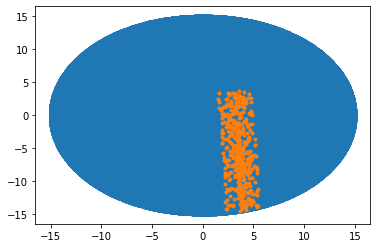

In [17]:
plt.scatter(gaiadata2[:,3], gaiadata2[:,2], marker = '.')
plt.scatter(gaiadata3_2[:,3], gaiadata3_2[:,2], marker = '.')
plt.show()

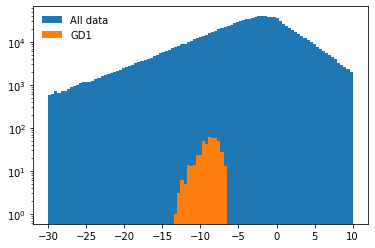

In [18]:
_,_,_=plt.hist(gaiadata2[:,0],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3_2[:,0],bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")

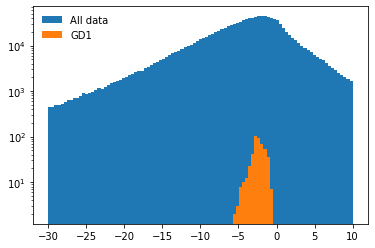

In [19]:
_,_,_=plt.hist(gaiadata2[:,1],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3_2[:,1],bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")

In [20]:
# gaiadata2 = gaiadata2[np.sum(np.isnan(gaiadata2),axis=1)==0]
# center_dec=0.5*(np.max(gaiadata2[:,2])+np.min(gaiadata2[:,2]))
# center_ra=0.5*(np.max(gaiadata2[:,3])+np.min(gaiadata2[:,3]))
# radius=np.sqrt((gaiadata2[:,2]-center_dec)**2+(gaiadata2[:,3]-center_ra)**2)
# gaiadata2=gaiadata2[radius<15]
# np.random.shuffle(gaiadata2)

In [21]:
gaiadata2 = gaiadata2[(np.abs(gaiadata2[:,0]) > 2) + (np.abs(gaiadata2[:,1]) > 2)] 

In [22]:
# scan_and_plot(gaiadata2, datafile)

In [23]:
gaiadata2 = gaiadata2[(gaiadata2[:,4]>0.5) * (gaiadata2[:,4]<1)]

In [24]:
gaiadata3_2 = gaiadata3_2[(np.abs(gaiadata3_2[:,0]) > 2) + (np.abs(gaiadata3_2[:,1]) > 2)] 
gaiadata3_2 = gaiadata3_2[(gaiadata3_2[:,4]>0.5) * (gaiadata3_2[:,4]<1)]

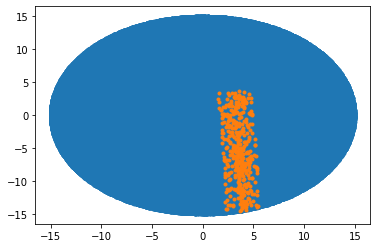

In [25]:
plt.scatter(gaiadata2[:,3], gaiadata2[:,2], marker = '.')
plt.scatter(gaiadata3_2[:,3], gaiadata3_2[:,2], marker = '.')
plt.show()

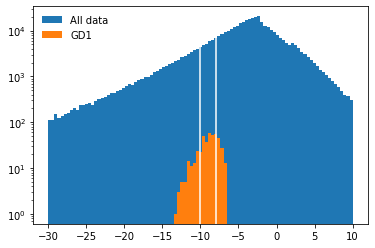

In [26]:
_,_,_=plt.hist(gaiadata2[:,0],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3_2[:,0],bins=np.linspace(-30,10,100),label="GD1")
plt.axvline(-10, color = 'white')
plt.axvline(-8, color = 'white')
plt.legend(frameon=False)
plt.yscale("log")

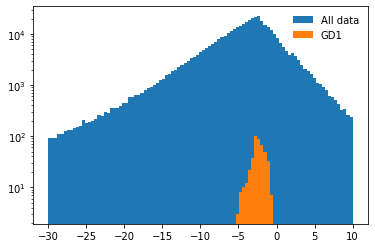

In [27]:
_,_,_=plt.hist(gaiadata2[:,1],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3_2[:,1],bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")

In [ ]:
#play around with the variables - modify signal region, reduce background - see when we can find it

27236 29003
working


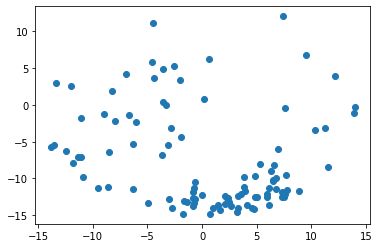

In [148]:
# #make a signal region between -13 and -8
# #see if you find it
# #stick with the scatterplots for now (coordinates) top 100 stars

# SR = gaiadata2[(gaiadata2[:,0] > -10)*(gaiadata2[:,0] < -8)]
# SB = gaiadata2[(gaiadata2[:,0] > -11)*(gaiadata2[:,0] < -10)+(gaiadata2[:,0] > -8)*(gaiadata2[:,0] < -7)]
# print(len(SR), len(SB))
# pointer1 = -13
# pointer2 = -8
# all_data = gaiadata2
# stream = gaiadata3_2

# X = np.concatenate([SR,SB])
# Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB))])

# myscalar = preprocessing.StandardScaler()
# myscalar.fit(X)
# X_scaled = myscalar.transform(X)
# all_data_scaled = myscalar.transform(all_data)

# X_scaled = X_scaled[Y<2]
# Y = Y[Y<2]


# X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

# print('working')

# #set biases for each layer, bias_initializer
# #initializers.GlorotNormal()
# model = Sequential()
# initializer =tf.keras.initializers.glorot_normal()
# model.add(Dense(64, input_dim=5, activation='relu', bias_initializer = initializer)) 
# model.add(Dense(64, activation='relu', bias_initializer = initializer))
# model.add(Dense(64, activation='relu', bias_initializer = initializer))
# model.add(Dense(1, activation='sigmoid', bias_initializer = initializer))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0) 

# preds = model.predict(X_test[:,1:], batch_size=int(0.1*len(X_test)))
# preds_all = model.predict(all_data_scaled[:, 1:])

# stars_passing_cut = []

# preds_all_sorted = preds_all[np.argsort(preds_all[:,0])]
# all_data_sorted = all_data[np.argsort(preds_all[:,0])]

# all_data_sorted = all_data_sorted[(all_data_sorted[:,0] > pointer1) * (all_data_sorted[:,0] < pointer2)]
# stars_passing_cut = all_data_sorted[len(all_data_sorted) - 100:]

# plt.scatter(stars_passing_cut[:,3],stars_passing_cut[:,2])
# plt.show()


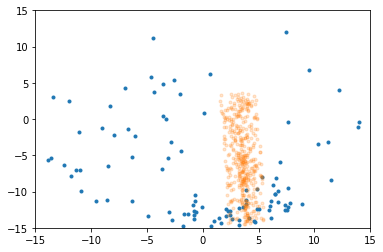

In [149]:
# plt.scatter(stars_passing_cut[:,3],stars_passing_cut[:,2], marker = '.')
# plt.scatter(gaiadata3_2[:,3], gaiadata3_2[:,2], marker = '.', alpha = 0.2)
# plt.xlim(-15,15)
# plt.ylim(-15,15)
# plt.show()

In [28]:
import random

In [81]:
half_background = []
for i in range(len(gaiadata2)):
    if gaiadata2[i][6]:
        half_background.append(gaiadata2[i])
    else:
        if random.randint(0, 100) < 100:
            half_background.append(gaiadata2[i])

In [82]:
len(half_background)

407916

In [75]:
len(gaiadata3_2)

437

In [76]:
half_background = np.array(half_background)

In [77]:
half_background = half_background[:, :6]

In [78]:
half_background

array([[  2.9949613 ,  -4.2464523 ,  11.117261  ,  -4.154719  ,
          0.96725273,  15.592352  ],
       [  2.3002617 ,  -9.497404  ,  11.37936   ,  -2.9897766 ,
          0.99129677,  17.711288  ],
       [  2.085793  ,  -5.463203  ,  10.900926  ,  -3.2868128 ,
          0.94268036,  17.155518  ],
       ...,
       [  3.8850095 ,  -8.802981  ,  -3.6471784 ,  -6.7978053 ,
          0.7040777 ,  15.80166   ],
       [ -5.779952  ,  -3.6985881 ,  -4.260559  ,  -7.3876834 ,
          0.7635174 ,  20.74055   ],
       [ -6.883007  , -11.181238  ,  -3.6301632 ,  -6.810846  ,
          0.71578026,  17.42906   ]], dtype=float32)

8296 8587
working


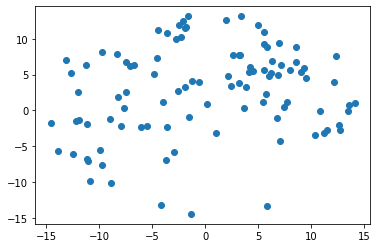

In [79]:
#make a signal region between -13 and -8
#see if you find it
#stick with the scatterplots for now (coordinates) top 100 stars

SR = half_background[(half_background[:,0] > -10)*(half_background[:,0] < -8)]
SB = half_background[(half_background[:,0] > -11)*(half_background[:,0] < -10)+(half_background[:,0] > -8)*(half_background[:,0] < -7)]
print(len(SR), len(SB))
pointer1 = -13
pointer2 = -8
all_data = half_background
stream = gaiadata3_2

X = np.concatenate([SR,SB])
Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB))])

myscalar = preprocessing.StandardScaler()
myscalar.fit(X)
X_scaled = myscalar.transform(X)
all_data_scaled = myscalar.transform(all_data)

X_scaled = X_scaled[Y<2]
Y = Y[Y<2]


X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

print('working')

#set biases for each layer, bias_initializer
#initializers.GlorotNormal()
model = Sequential()
initializer =tf.keras.initializers.glorot_normal()
model.add(Dense(64, input_dim=5, activation='relu', bias_initializer = initializer)) 
model.add(Dense(64, activation='relu', bias_initializer = initializer))
model.add(Dense(64, activation='relu', bias_initializer = initializer))
model.add(Dense(1, activation='sigmoid', bias_initializer = initializer))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0) 

preds = model.predict(X_test[:,1:], batch_size=int(0.1*len(X_test)))
preds_all = model.predict(all_data_scaled[:, 1:])

stars_passing_cut = []

preds_all_sorted = preds_all[np.argsort(preds_all[:,0])]
all_data_sorted = all_data[np.argsort(preds_all[:,0])]

all_data_sorted = all_data_sorted[(all_data_sorted[:,0] > pointer1) * (all_data_sorted[:,0] < pointer2)]
stars_passing_cut = all_data_sorted[len(all_data_sorted) - 100:]

plt.scatter(stars_passing_cut[:,3],stars_passing_cut[:,2])
plt.show()



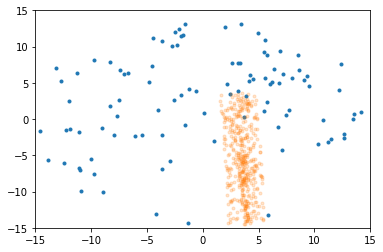

In [80]:
plt.scatter(stars_passing_cut[:,3],stars_passing_cut[:,2], marker = '.')
plt.scatter(gaiadata3_2[:,3], gaiadata3_2[:,2], marker = '.', alpha = 0.2)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()

In [58]:
datafiles = ['/data0/users/bpnachman/Gaia/gaiascan_l101.2_b58.4_ra212.7_dec55.2.npy']
for datafile in datafiles: 
    gaiadata=np.load(datafile,allow_pickle=True)
    gaiadata2 = np.array(gaiadata[:,[9,8,6,7,4,5]]).astype('float32') 
    #pm_lat, pm_lon_coslat, lon, lat, color, mag
    
    gaiadata2 = gaiadata2[np.sum(np.isnan(gaiadata2),axis=1)==0]
    center_dec=0.5*(np.max(gaiadata2[:,2])+np.min(gaiadata2[:,2]))
    center_ra=0.5*(np.max(gaiadata2[:,3])+np.min(gaiadata2[:,3]))
    radius=np.sqrt((gaiadata2[:,2]-center_dec)**2+(gaiadata2[:,3]-center_ra)**2)
    gaiadata2=gaiadata2[radius<15]
    np.random.shuffle(gaiadata2)

    #remove between -2 and 2
    #gaiadata2 = gaiadata2[(np.abs(gaiadata2[:,0]) > 2) + (np.abs(gaiadata2[:,1]) > 2)] 
    
    #pick 100 stars to plot
    #scan_and_plot(gaiadata2, datafile)

In [8]:
#function from David's file via_machinae.py
def FilterGD1(stars):
    gd1stars=np.zeros(len(stars))
    for x in allgd1stars:
        ra=x[0]
        dec=x[1]
        pmra=x[2]
        pmdec=x[3]
    #    print(ra,dec,pmra,pmdec)
    
        foundlist=angular_distance(np.dstack((stars[:,3],stars[:,2]))[0],np.array([[ra,dec]]))
        foundlist=np.sqrt(foundlist**2+(stars[:,0]-pmdec)**2+(stars[:,1]-pmra)**2)   
        foundlist=foundlist<.0001
        if len(np.argwhere(foundlist))>1:
            print(foundlist)
        if len(np.argwhere(foundlist))==1:
#            ngd1+=1
            gd1stars+=foundlist
#    print(ngd1)
    gd1stars=gd1stars.astype('bool')
    return gd1stars,stars[gd1stars]

In [9]:
def angular_distance(angle1,angle2):
    # inputs are np arrays of [ra,dec]
    deltara=np.minimum(np.minimum(np.abs(angle1[:,0]-angle2[:,0]+360),np.abs(angle1[:,0]-angle2[:,0])),\
                          np.abs(angle1[:,0]-angle2[:,0]-360))
    deltadec=np.abs(angle1[:,1]-angle2[:,1])
    return np.sqrt(deltara**2+deltadec**2)

In [150]:
#TEST


datafile="/data0/users/bpnachman/Gaia/GD1-circle-140-30-15.pkl"
gaiadata=np.load(datafile,allow_pickle=True)
print(gaiadata)
gaiadata=np.array(gaiadata[['pmdec','pmra','dec','ra']].astype('float32'))
is_stream_arr, gaiadata3 = FilterGD1(gaiadata)

                  source_id          ra  ra_error        dec  dec_error  \
0        635693677075094656  139.049854  0.529200  19.016067   0.463755   
1        635871596095472768  138.323686  0.048942  19.128199   0.043735   
2        635634647044221184  139.627539  0.430870  18.969149   0.348081   
3        635632211798449280  139.590380  0.082537  18.873516   0.071441   
4        635660794805413376  138.800571  0.125533  18.798913   0.155002   
...                     ...         ...       ...        ...        ...   
1238727  619665275738303232  145.533189  0.038745  16.224394   0.032285   
1238728  619725126107390464  146.407091  0.163076  16.343047   0.144811   
1238729  619754881640871296  146.059863  0.523653  16.451545   0.557185   
1238730  619659636446280192  145.537988  0.201689  16.102909   0.137683   
1238731  619740626644506240  145.988660  0.079135  16.180184   0.116997   

         parallax  parallax_error  parallax_over_error       pmra  pmra_error  \
0       -0.338469 

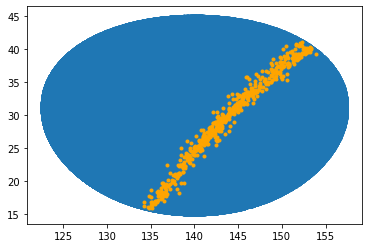

In [55]:
plt.scatter(gaiadata[:,3], gaiadata[:,2], marker = '.')
plt.scatter(gaiadata3[:,3], gaiadata3[:,2], marker = '.', color = 'orange')

In [51]:
print(gaiadata)

[[139.04985     19.016068    -3.5494444   -3.670401  ]
 [138.32368     19.128199   -12.946452    -0.3446589 ]
 [139.62753     18.969149   -17.36547    -19.620848  ]
 ...
 [146.05986     16.451546    -2.886816   -11.404234  ]
 [145.538       16.10291     -2.8119686   -3.975448  ]
 [145.98866     16.180183    -0.75711423  -7.1241684 ]]


In [50]:
print(allgd1stars)

[[142.45789086  25.43553735  -4.14616022 -11.32511459]
 [140.82282112  24.73126659  -4.38695134 -12.77121859]
 [142.8562862   26.15404918  -3.02662392  -9.06044392]
 ...
 [196.68339465  59.64359889  -8.45724365  -4.59369392]
 [197.35946451  59.49564252  -7.06616891  -3.4935051 ]
 [196.16371828  59.57436137  -7.92536588  -3.05662424]]
